# Background

Simple churn prediction analysis (whether client leaves a bank or not).

In [726]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

# Import Dataset

In [727]:
df = pd.read_csv('Churn_Modelling.csv')

In [728]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [729]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [730]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [731]:
target = 'Exited'
cat_cols = ['Geography', 'Gender']
num_cols = [col for col in df.columns if col not in [target, cat_cols[0], cat_cols[1], 'HasCrCard', 'IsActiveMember']]

# Train-test division

In [732]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(target, axis=1), df[target], test_size=.25, random_state=0)

# Label Encoding categorical feature

In [733]:
l_encoder = LabelEncoder()
X_train[cat_cols[0]] = l_encoder.fit_transform(X_train[cat_cols[0]])

# One hot encoding categorical feature

In [734]:
oh_encoder = OneHotEncoder(sparse=False, drop='first')

In [735]:
X_train['Gender_male'] = oh_encoder.fit_transform(X_train[cat_cols[1]].values.reshape(-1,1))

In [736]:
X_train.drop(cat_cols[1], axis=1, inplace=True)

In [737]:
X_test[cat_cols[0]] = l_encoder.transform(X_test[cat_cols[0]])
X_test['Gender_male'] = oh_encoder.transform(X_test[cat_cols[1]].values.reshape(-1,1))
X_test.drop(cat_cols[1], axis=1, inplace=True)

# Scaling numerical values

In [739]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [740]:
X_train.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_male
2967,-0.735507,1,0.015266,0.008860,0.673160,2.535034,0,0,-1.640810,0.0
700,1.024427,0,-0.652609,0.008860,-1.207724,0.804242,1,0,-0.079272,0.0
3481,0.808295,2,-0.461788,1.393293,-0.356937,0.804242,1,1,-0.996840,0.0
1621,0.396614,2,-0.080145,0.008860,-0.009356,-0.926551,1,1,-1.591746,1.0
800,-0.467915,0,1.255605,0.701077,-1.207724,0.804242,1,1,1.283302,1.0


In [741]:
X_test.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_male
9394,-0.550251,1,-0.366377,1.047185,0.884943,-0.926551,1,1,1.612030,0.0
898,-1.311860,0,0.110676,-1.029464,0.435867,-0.926551,1,0,0.496269,0.0
2398,0.571579,2,0.301498,1.047185,0.314864,-0.926551,1,1,-0.425028,0.0
5906,1.415524,0,-0.652609,-0.337248,0.581318,-0.926551,0,0,-0.187853,1.0
2343,0.571579,1,-0.080145,0.008860,1.394678,0.804242,1,1,0.617324,1.0


In [742]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float).cuda()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float).cuda()

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).flatten().cuda()
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).flatten().cuda()

In [743]:
X_train_tensor

tensor([[-0.7355,  1.0000,  0.0153,  ...,  0.0000, -1.6408,  0.0000],
        [ 1.0244,  0.0000, -0.6526,  ...,  0.0000, -0.0793,  0.0000],
        [ 0.8083,  2.0000, -0.4618,  ...,  1.0000, -0.9968,  0.0000],
        ...,
        [ 0.9009,  0.0000, -0.3664,  ...,  0.0000,  1.4134,  1.0000],
        [-0.6223,  2.0000, -0.0801,  ...,  1.0000,  0.8450,  0.0000],
        [-0.2827,  1.0000,  0.8740,  ...,  0.0000,  0.3250,  0.0000]],
       device='cuda:0')

In [744]:
y_train_tensor

tensor([1., 0., 0.,  ..., 0., 0., 1.], device='cuda:0')

# NN module creation

Two hidden layers (fully connected) with ReLU activation function and output layer with sigmoid function (because this is binary classification).

In [745]:
class ChurnClassNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(10, 6),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(6, 6),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(6, 1),
                                    nn.Sigmoid())

    def forward(self, X):
        return self.layers(X)

In [746]:
torch.manual_seed(0)
model = ChurnClassNet().cuda()

In [747]:
for param in model.parameters():
    print(param.numel())

60
6
36
6
6
1


In [748]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [749]:
from sklearn.metrics import accuracy_score

In [750]:
from torch.utils.data import DataLoader

In [751]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset= torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [752]:
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=10,
                         shuffle=True)

# Network training

In [753]:
import time
start_time = time.time()

epochs = 100
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for i in range(epochs):
    i += 1
    trn_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train.reshape(-1,1))
        y_pred = y_pred.cpu()
        y_pred = np.where(y_pred > .5, 1, 0)
        y_pred = y_pred.reshape(1,-1)
        batch_corr = (y_pred == y_train.cpu().numpy()).sum()
        trn_corr += batch_corr
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    trn_acc = trn_corr/7500
    train_accuracy.append(trn_acc)
    train_loss.append(loss)
    
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        tst_loss = criterion(y_pred, y_test_tensor.reshape(-1,1))
        test_loss.append(tst_loss)
        
        y_pred = y_pred.cpu()
        y_pred = np.where(y_pred > .5, 1,0)
        tst_acc = accuracy_score(y_test, y_pred)
        test_accuracy.append(tst_acc)
    if i%5==0:
        print(f'Epoch: {i} Loss: {loss.item()} Accuracy: {trn_acc*100:.2f} Test Accuracy: {tst_acc*100:.2f}')

print(f'Duration of training: {(time.time() - start_time)/60:.2f} minutes')

Epoch: 5 Loss: 0.2435123473405838 Accuracy: 82.32 Test Accuracy: 83.56
Epoch: 10 Loss: 0.5694916844367981 Accuracy: 84.36 Test Accuracy: 85.20
Epoch: 15 Loss: 0.16298285126686096 Accuracy: 85.09 Test Accuracy: 85.88
Epoch: 20 Loss: 0.6412947773933411 Accuracy: 85.27 Test Accuracy: 85.96
Epoch: 25 Loss: 0.11677823215723038 Accuracy: 85.80 Test Accuracy: 85.96
Epoch: 30 Loss: 0.21116474270820618 Accuracy: 85.35 Test Accuracy: 86.12
Epoch: 35 Loss: 0.415447473526001 Accuracy: 85.63 Test Accuracy: 86.08
Epoch: 40 Loss: 0.6681535840034485 Accuracy: 85.71 Test Accuracy: 86.12
Epoch: 45 Loss: 0.10102848708629608 Accuracy: 85.68 Test Accuracy: 86.28
Epoch: 50 Loss: 0.07432686537504196 Accuracy: 85.76 Test Accuracy: 86.32
Epoch: 55 Loss: 0.11757679283618927 Accuracy: 85.57 Test Accuracy: 85.48
Epoch: 60 Loss: 0.492320716381073 Accuracy: 85.59 Test Accuracy: 86.24
Epoch: 65 Loss: 0.2830164432525635 Accuracy: 85.83 Test Accuracy: 86.00
Epoch: 70 Loss: 0.4734157919883728 Accuracy: 85.71 Test Accur

# Metrics vizualizations

Text(0, 0.5, 'Binary CrossEntropy Loss')

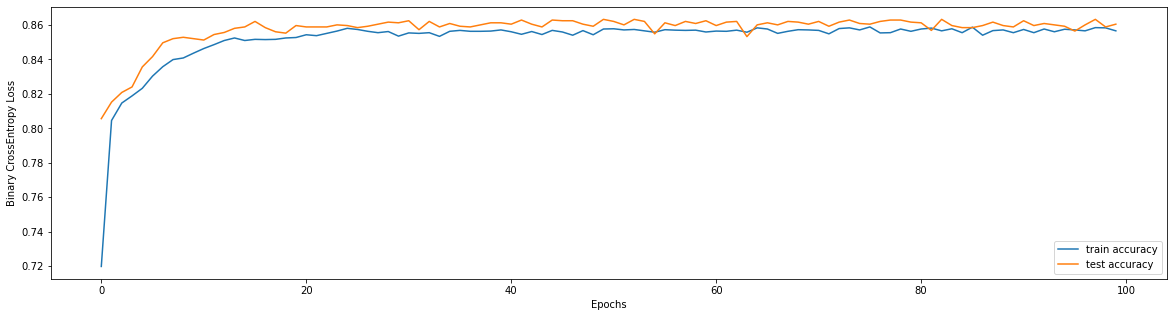

In [754]:
plt.figure(figsize=(20,5))
plt.plot(range(epochs), train_accuracy, label = 'train accuracy')
plt.plot(range(epochs), test_accuracy, label = 'test accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary CrossEntropy Loss')

Text(0, 0.5, 'Accuracy score')

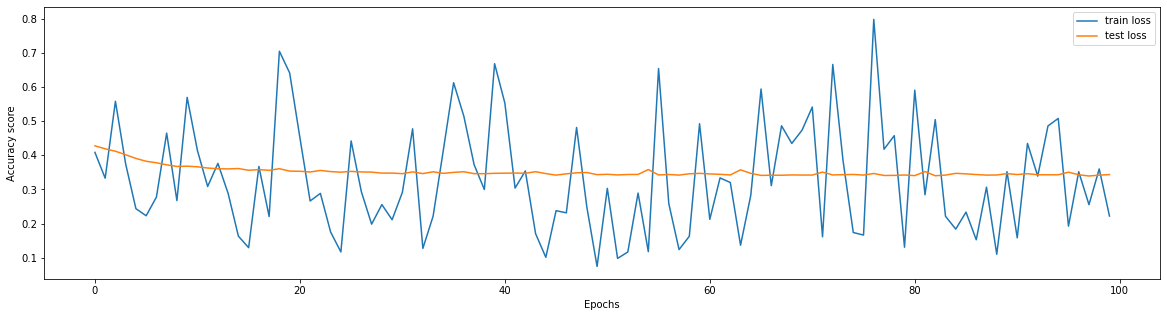

In [755]:
plt.figure(figsize=(20,5))
plt.plot(range(epochs), train_loss, label = 'train loss')
plt.plot(range(epochs), test_loss, label = 'test loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy score')

# ROC curve to set bes threshold

In [756]:
with torch.no_grad():
    y_pred = model(X_test_tensor)

In [757]:
from sklearn.metrics import roc_curve

In [758]:
fpr, tpr, threshold = roc_curve(y_test, y_pred.cpu())

Text(0, 0.5, 'True Positive Ratio')

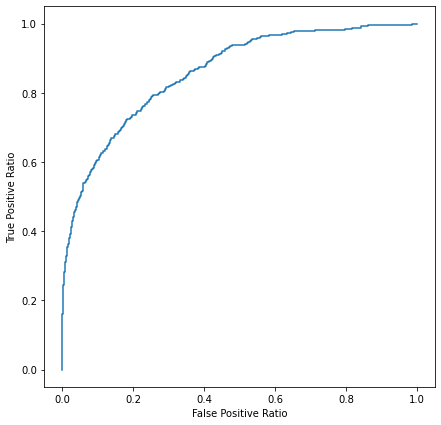

In [759]:
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')

In [760]:
threshold[(tpr >=.8) & (tpr <=.85) & (fpr >= .3) & (fpr <= .35)].mean()

0.15821494

Basing on test data - best theshold would be somewhere around 0,16.

# Next steps

Change categorical variables to embedding.